In [1]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

from bert import BERT, BERTTSM
from dataset import TSMDataset
from build_vocab import WordVocab
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [3]:
class TSMTrainer:
    def __init__(self, bert: BERT, vocab_size: int,
                 train_dataloader: DataLoader, test_dataloader: DataLoader = None,
                 lr: float = 1e-4, betas=(0.9, 0.999), weight_decay: float = 0.01,
                 log_freq: int = 10, gpu_ids=[], vocab=None):
        """
        :param bert: BERT model
        :param vocab_size: vocabに含まれるトータルの単語数
        :param train_dataloader: train dataset data loader
        :param test_dataloader: test dataset data loader [can be None]
        :param lr: 学習率
        :param betas: Adam optimizer betas
        :param weight_decay: Adam optimizer weight decay param
        :param with_cuda: traning with cuda
        :param log_freq: logを表示するiterationの頻度
        """

        # GPU環境において、GPUを指定しているかのフラグ
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert = bert
        self.model = BERTTSM(bert).to(self.device)

        if self.device == 'cuda':
            self.model = nn.DataParallel(self.model, gpu_ids)

        self.train_data = train_dataloader
        self.test_data = test_dataloader

        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.criterion = nn.NLLLoss()
        self.log_freq = log_freq
        self.vocab = vocab
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
        

    def train(self, epoch):
        loss, acc = self.iteration(epoch, self.train_data)
        return loss, acc

    def test(self, epoch):
        loss, acc = self.iteration(epoch, self.test_data, train=False)
        return loss, acc

    def iteration(self, epoch, data_loader, train=True):
        """
        :param epoch: 現在のepoch
        :param data_loader: torch.utils.data.DataLoader
        :param train: trainかtestかのbool値
        """
        str_code = "train" if train else "test"
        data_iter = tqdm(enumerate(data_loader), desc="EP_%s:%d" % (str_code, epoch), total=len(data_loader), bar_format="{l_bar}{r_bar}")

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        for i, data in data_iter:
            # 0. batch_dataはGPU or CPUに載せる
            data = {key: value.to(self.device) for key, value in data.items()}
            tsm= self.model.show(data["bert_input"], data["segment_embd"])
            x = torch.Tensor.numpy(data["bert_input"][:30].detach().cpu()).reshape((-1))
            print(x)
            arg2 = np.where(x==2)[0]
            tsm = torch.Tensor.numpy(tsm.detach().cpu()).reshape((-1,1024))
            X1, X2 = tsm[1:arg2[0], :], tsm[arg2[0]+1:arg2[1], :]
            if len(X1)==len(X2):
                sims = [cos_sim(x1, x2) for x1,x2 in zip(X1,X2)]
                print('Cosine Similarity', sims, np.mean(sims))
                sims = [np.corrcoef(x1, x2) for x1,x2 in zip(X1,X2)]
                print('Correlation Coefficiency', sims, np.mean(sims))
            plt.figure(figsize=(16,16))
            plt.imshow(tsm[:30,:].T, aspect=1/30, cmap='hsv')
            plt.colorbar()
            return  None

In [4]:
def main():
    parser = argparse.ArgumentParser(description='Pretrain SMILES Transformer')
    parser.add_argument('--n_epoch', '-e', type=int, default=1, help='number of epochs')
    parser.add_argument('--vocab', '-v', type=str, default='data/vocab.pkl', help='vocabulary (.pkl)')
    parser.add_argument('--train_data', type=str, default='data/gdb05_bert_train.csv', help='train corpus (.csv)')
    parser.add_argument('--test_data', type=str, default='data/gdb05_bert_test.csv', help='test corpus (.csv)')
    parser.add_argument('--out-dir', '-o', type=str, default='../result', help='output directory')
    parser.add_argument('--name', '-n', type=str, default='ST', help='model name')
    parser.add_argument('--seq_len', type=int, default=203, help='maximum length of the paired seqence')
    parser.add_argument('--batch_size', '-b', type=int, default=1, help='batch size')
    parser.add_argument('--n_worker', '-w', type=int, default=16, help='number of workers')
    parser.add_argument('--hidden', type=int, default=1024, help='length of hidden vector')
    parser.add_argument('--n_layer', '-l', type=int, default=4, help='number of layers')
    parser.add_argument('--n_head', type=int, default=4, help='number of attention heads')
    parser.add_argument('--dropout', '-d', type=float, default=0.1, help='dropout rate')
    parser.add_argument('--lr', type=float, default=4e-4, help='Adam learning rate')
    parser.add_argument('--beta1', type=float, default=0.9, help='Adam beta1')
    parser.add_argument('--beta2', type=float, default=0.999, help='Adam beta2')
    parser.add_argument('--weight-decay', type=float, default=0.01, help='dropout rate')
    parser.add_argument('--log-freq', type=int, default=100, help='log frequency')
    parser.add_argument('--gpu', type=int, default=0, help='list of GPU IDs to use')
    parser.add_argument('--checkpoint', '-c', type=str, default='../result/GDB05/ep_999.pkl', help='Parameter to load')
    args = parser.parse_args([])

    print("Loading Vocab", args.vocab)
    vocab = WordVocab.load_vocab(args.vocab)
    print("Loading Train Dataset", args.train_data)
    train_dataset = TSMDataset(args.train_data, vocab, seq_len=args.seq_len)
    print("Loading Test Dataset", args.test_data)
    test_dataset = TSMDataset(args.test_data, vocab, seq_len=args.seq_len)
    print("Creating Dataloader")
    train_data_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=args.n_worker)
    test_data_loader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.n_worker) 
    print("Building BERT model")
    bert = BERT(len(vocab), hidden=args.hidden, n_layers=args.n_layer, attn_heads=args.n_head, dropout=args.dropout)
    if args.checkpoint:
        print('Load', args.checkpoint)
        bert.load_state_dict(torch.load(args.checkpoint))
    bert.cuda()
    print("Creating BERT Trainer")
    trainer = TSMTrainer(bert, len(vocab), train_dataloader=train_data_loader, test_dataloader=test_data_loader,
                        lr=args.lr, betas=(args.beta1, args.beta2), weight_decay=args.weight_decay,
                        log_freq=args.log_freq, gpu_ids=args.gpu, vocab=vocab)

    print("Training Start")
    for epoch in tqdm(range(args.n_epoch)):
        loss, acc = trainer.train(epoch)
        print('EP%d Train| loss:{:.4f}, accuracy{:.4f}'.format(loss, acc))
        
        loss, acc = trainer.test(epoch)

Loading Vocab data/vocab.pkl
Loading Train Dataset data/gdb05_bert_train.csv
Loading Test Dataset data/gdb05_bert_test.csv
Creating Dataloader
Building BERT model
Load ../result/GDB05/ep_999.pkl


  0%|          | 0/1 [00:00<?, ?it/s]

Creating BERT Trainer
Total Parameters: 50436098
Training Start
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1


O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1


EP_train:0:   0%|| 0/79 [00:00<?, ?it/s]

O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1
O1C=CC=N1 O1N=NN=C1


[ 3  9 11  6 10  6  6 10 12 11  2  9 11 12 10 12 12 10  6 11  2  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]
SIM [0.007431562, 0.01944956, -0.20384128, -0.009293049, -0.31437844, -0.31092533, 0.002580736, -0.24968548, -0.018413067]


TypeError: 'NoneType' object is not iterable

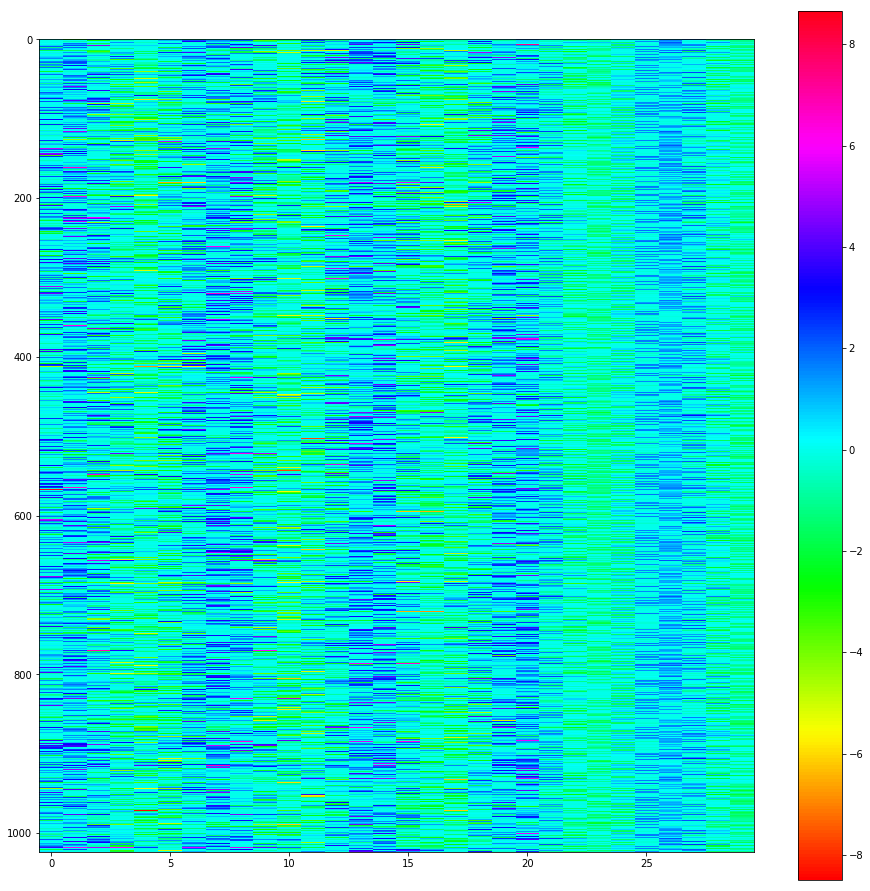

In [5]:
main()

In [9]:
a = [0.06828998, -0.030475, -0.04419308, -0.008038747, -0.06933358, -0.07159146, 0.025123263, -0.02171991, -0.03210371]

np.mean(a)

-0.020449138222222225